In [1]:
import pandas as pd

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import to_date, col, date_format
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
import matplotlib.pyplot as plt

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.driver.memory", "14g") \
    .appName('my-cool-app') \
    .getOrCreate()

sc=spark.sparkContext

23/02/10 03:03:01 WARN Utils: Your hostname, abdi-VivoBook-ASUSLaptop-X415EP-R465EP resolves to a loopback address: 127.0.1.1; using 172.27.172.43 instead (on interface wlo1)
23/02/10 03:03:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 03:03:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#making a schema for our dataFrame
schema = StructType([ \
        StructField("DEVICE_CODE", StringType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [4]:
df=spark.read.csv('MDA2022ProjectData.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010047|      284|       63455590|     63455590|               6|       161|2021-12-22 00:59:30|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [5]:
#adding a name of day_week column to data frame
df = df.withColumn('date', to_date(df.PASS_DAY_TIME))
df = df.withColumn("day_of_week", date_format(col("date"), "EEEE"))

In [6]:
#filtering just one week of a dataframe and just one day of it
traffic_df = df.filter(df.PASS_DAY_TIME > "2021-12-26")
traffic_df = traffic_df.filter(traffic_df.PASS_DAY_TIME < "2022-01-04" )


In [7]:
traffic_df.repartition(1).write.csv('SampleData_Week.csv',header=True)

In [4]:
df = spark.read.csv('SampleData_Wednesday.csv',header=True,schema=schema)

In [5]:
#adding day of week column to dataframe
df = df.withColumn('date', to_date(df.PASS_DAY_TIME))
df = df.withColumn("day_of_week", date_format(col("date"), "EEEE"))

In [6]:
#dividing day to 4 part of time for analyzing high traffic time of a day
first_six_df = df.filter(df.PASS_DAY_TIME > "2021-12-29 00:00:00")
first_six_df = first_six_df.filter(first_six_df.PASS_DAY_TIME < "2021-12-29 06:00:00")

second_six_df = df.filter(df.PASS_DAY_TIME > "2021-12-29 06:00:00")
second_six_df = second_six_df.filter(second_six_df.PASS_DAY_TIME < "2021-12-29 12:00:00")

third_six_df = df.filter(df.PASS_DAY_TIME > "2021-12-29 12:00:00")
third_six_df = third_six_df.filter(third_six_df.PASS_DAY_TIME < "2021-12-29 18:00:00")

forth_six_df = df.filter(df.PASS_DAY_TIME > "2021-12-29 18:00:00")
forth_six_df = forth_six_df.filter(forth_six_df.PASS_DAY_TIME < "2021-12-29 23:59:59")

In [7]:
df.show(1)

23/02/09 22:16:25 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----------+-----------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|      date|day_of_week|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----------+-----------+
|     900174|      283|       91843693|     91843693|               5|       264|2021-12-29 07:15:35|2021-12-29|  Wednesday|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----------+-----------+
only showing top 1 row



In [8]:
#making key and value for analyzing
#we don't need x['PASS_DAY_TIME'].date() here in key because we are analysing just one day but it is ok to handle it
Traffic = df.rdd.map(lambda x: ((x['FINAL_CAR_KEY'] , x['PASS_DAY_TIME'].date()), (x['DEVICE_CODE'] , x['PASS_DAY_TIME']) ))


In [9]:
#now we groupby items based on ther keys and then we are making a set of values to have camera_ids for each car
Traffic = Traffic.groupByKey()
Traffic = Traffic.map(lambda x : (x[0],sorted(set(list(x[1])))))

In [10]:
#we want to analysis traffic so we don't need to keep car_id's
from operator import add
Traffic = Traffic.map(lambda x : tuple(x[1]))



In [11]:
#in this function that Im gonna apply it to Traffic
#in this function at first step Im sorting cameras by the time 
#so now each two cameras in the list that are neighbour we can assume that they are neighbour in real_word too
#also I'm filtering cameras that are apperaed twice

import datetime
def sort_by_date(x):
    x = list(x)
    x.sort(key = lambda a:a[1])
    new_list = []
    for i in range(len(x)-1):
        minutes_between_neighbour = int((x[i+1][1]-x[i][1]).total_seconds() / 60)
        if minutes_between_neighbour > 10 and minutes_between_neighbour < 70:
            if x[i][0] != x[i+1][0]:
                new_list.append(((x[i][0] , x[i+1][0]), minutes_between_neighbour))
    return new_list


In [12]:

Traffic = Traffic.map(lambda x : sort_by_date(x))

In [13]:
#here we want to calculate that each neighbour cameras are appeared in this day
Traffic = Traffic.flatMap(lambda x : x).map(lambda x: (x[0],1)).reduceByKey(add)


In [14]:
Traffic = Traffic.sortBy(lambda x : -x[1])

23/02/09 22:16:40 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv


In [15]:
Traffic_list = Traffic.collect()
Traffic_list

[(('631634', '100700853'), 4522),
 (('900244', '631633'), 3848),
 (('900268', '900225'), 3728),
 (('900269', '900259'), 3282),
 (('900142', '900212'), 3027),
 (('100700841', '900101'), 2937),
 (('100700853', '900142'), 2825),
 (('100700864', '900185'), 2739),
 (('631765', '100700820'), 2426),
 (('900225', '900269'), 2366),
 (('631634', '100700841'), 2187),
 (('22010087', '22010088'), 2064),
 (('900246', '900234'), 2007),
 (('900226', '900269'), 1974),
 (('900215', '900234'), 1920),
 (('900222', '900155'), 1902),
 (('900269', '900225'), 1781),
 (('100700820', '900164'), 1640),
 (('100700853', '900152'), 1627),
 (('203902', '900191'), 1605),
 (('900193', '100700853'), 1599),
 (('631634', '900207'), 1584),
 (('900152', '900212'), 1538),
 (('22010039', '900101'), 1370),
 (('900207', '900225'), 1333),
 (('900234', '22010118'), 1288),
 (('900217', '22009971'), 1274),
 (('900185', '100700864'), 1257),
 (('900256', '22010118'), 1240),
 (('631357', '900217'), 1235),
 (('100700841', '22010040'),

In [16]:
most_100_cameras = Traffic_list[:100]


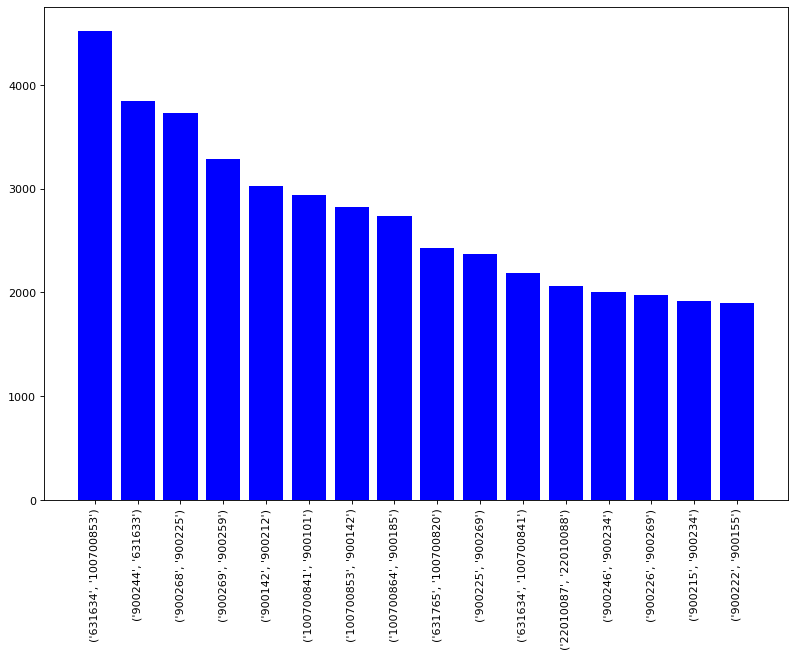

In [104]:
#here I want to plot counts of cars for each_neighbour cameras 
x_list = []
x_tick = []
y_list = []
for i , item in enumerate(most_100_cameras):
    if i > 15:
        break
    x_list.append(i)
    x_tick.append(item[0])
    y_list.append(item[1])

plt.figure(figsize=(12, 8), dpi=80)
plt.bar(x_list, y_list, color='b')
plt.xticks(x_list, x_tick, rotation='vertical')
plt.show()

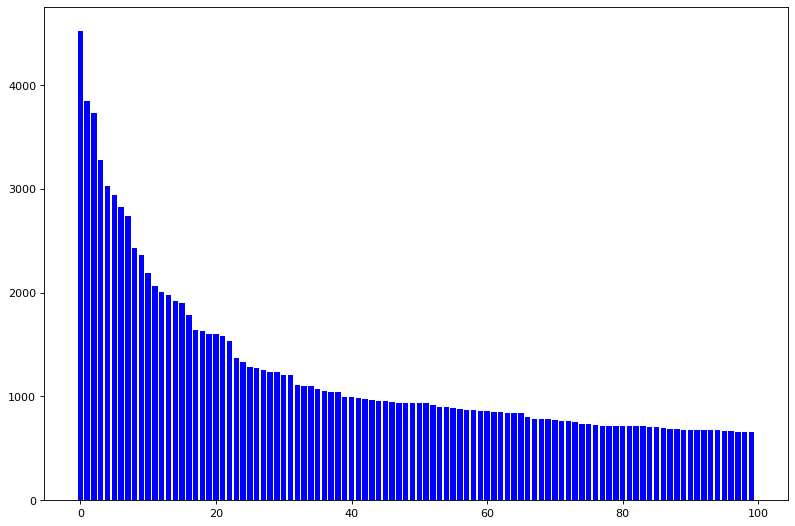

In [105]:
# and this plot is for first 100 neighbour cameras
x_list = []
x_tick = []
y_list = []
for i , item in enumerate(most_100_cameras):
    x_list.append(i)
    x_tick.append(item[0])
    y_list.append(item[1])

plt.figure(figsize=(12, 8), dpi=80)
plt.bar(x_list, y_list, color='b')
# plt.xticks(x_list, x_tick, rotation='vertical')
plt.show()

In [20]:
#this function is making path from neighbour camera's list
def make_path(pair_camera_list):
    high_traffic_road = [[]for i in range(70)]
    for pair in pair_camera_list:
        first , second = pair[0]
        flag = 0
        for temp in high_traffic_road:
            if first in temp:
                if second not in temp:
                    temp.append(second)
                flag = 1
                break
            elif second in temp:
                if first not in temp:
                    temp.append(first)
                flag = 1
                break
        for temp in high_traffic_road:
            if len(temp) == 0:
                temp.append(first)
                temp.append(second)
                break
    return high_traffic_road



In [21]:
path_for_day = make_path(most_100_cameras)
for path in path_for_day:
    print(path)

['631634', '100700853', '900142', '100700841', '900152', '900193', '900207', '900212', '900225', '22010040', '900273', '900243', '631633', '900269', '900208', '900244', '100701096', '900268', '900102', '22009977', '22010039', '900222', '900104', '900202', '631357', '900246', '100700812']
['900244', '631633']
['900268', '900225', '900269', '900226', '900227', '22009977', '900259', '900141']
['900269', '900259']
['900142', '900212']
['100700841', '900101', '22010039', '145', '101301', '114']
['100700853', '900142']
['100700864', '900185', '900191', '900151']
['631765', '100700820', '900164', '230204']
['900225', '900269']
['631634', '100700841']
['22010087', '22010088', '22010094']
['900246', '900234', '900215', '22010118', '900256', '631829', '100700881', '900217', '900141', '631357', '631795', '631763', '900158', '900255', '100700804']
['900226', '900269']
['900215', '900234']
['900222', '900155']
['900269', '900225']
['100700820', '900164']
['100700853', '900152']
['203902', '900191']

In [22]:
all = []
all.append(first_six_df)
all.append(second_six_df)
all.append(third_six_df)
all.append(forth_six_df)

In [23]:
#this part is just explained before and we are analysing this unique day for 4 part of 6_hours time
neighnour_cam_list = [[] for i in range(4)]
high_traffic_path_list = [[] for i in range(4)]
for index , hour_df  in enumerate (all):
    hour_df = hour_df.rdd.map(lambda x: ((x['FINAL_CAR_KEY'] , x['PASS_DAY_TIME'].date()), (x['DEVICE_CODE'] , x['PASS_DAY_TIME']) ))
    hour_df = hour_df.groupByKey()
    hour_df = hour_df.map(lambda x : (x[0],sorted(set(list(x[1])))))
    hour_df = hour_df.map(lambda x : tuple(x[1]))
    hour_df = hour_df.map(lambda x : sort_by_date(x))
    hour_df = hour_df.flatMap(lambda x : x).map(lambda x: (x[0],1)).reduceByKey(add)
    hour_df = hour_df.sortBy(lambda x : -x[1])
    temp_df = hour_df.collect()
    most_100_cameras = temp_df[:100]
    path_list = make_path(most_100_cameras)
    neighnour_cam_list[index].append(temp_df)
    high_traffic_path_list[index].append(path_list)    



23/02/09 22:28:16 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv


23/02/09 22:28:24 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv


23/02/09 22:28:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv


23/02/09 22:29:06 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Wednesday.csv/part-00000-d369a0f2-087a-4e02-b4b8-c5f2b9563970-c000.csv


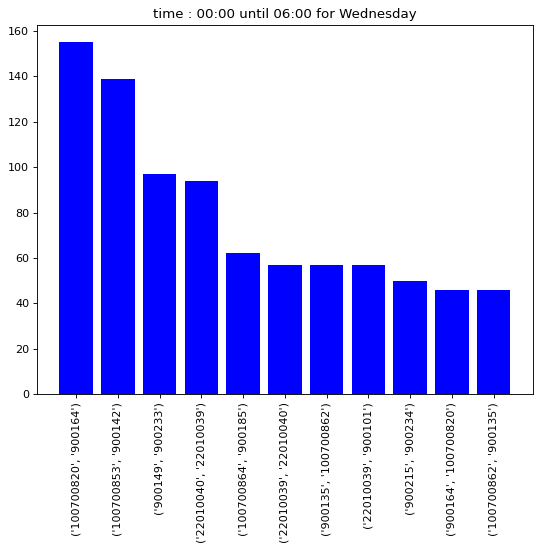

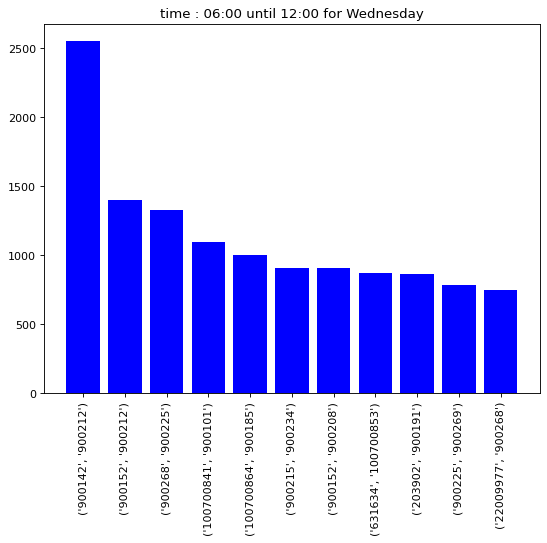

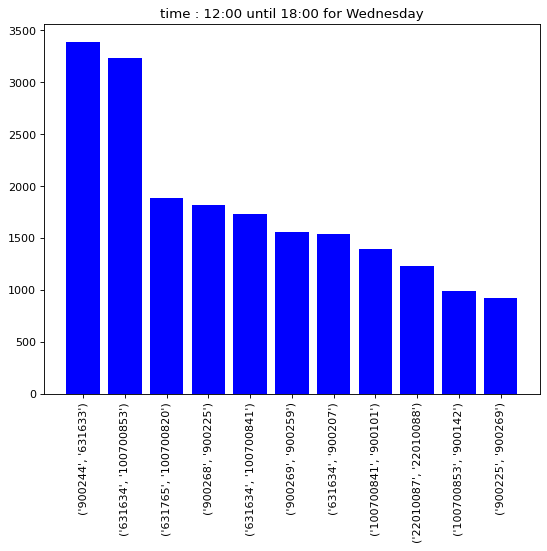

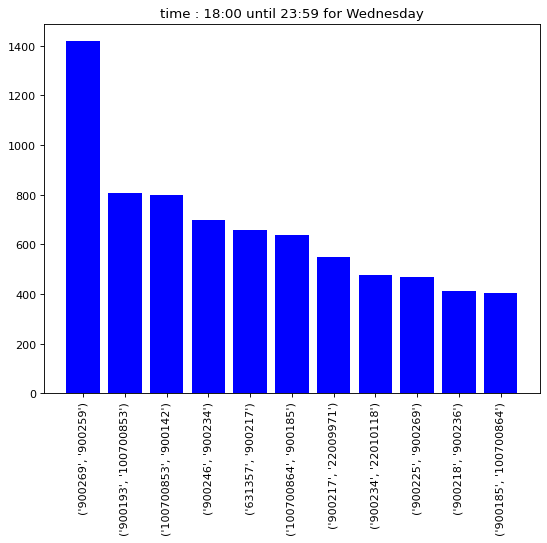

In [24]:
#now we just want to plot items
for i in range(4):
    title_str = ''
    if i == 0:
        title_str = "time : 00:00 until 06:00 for Wednesday"
    if i == 1:
        title_str = "time : 06:00 until 12:00 for Wednesday"
    if i == 2:
        title_str = "time : 12:00 until 18:00 for Wednesday"
    if i == 3:
        title_str = "time : 18:00 until 23:59 for Wednesday"

    x_list = []
    x_tick = []
    y_list = []
    for index , item in enumerate(neighnour_cam_list[i][0]):
        if index > 10:
            break
        x_list.append(index)
        x_tick.append(item[0])
        y_list.append(item[1])

    plt.figure(figsize=(8, 6), dpi=80)
    plt.bar(x_list, y_list, color='b')
    plt.xticks(x_list, x_tick, rotation='vertical')
    plt.title(title_str)
    plt.show()